In [15]:
#  SARIMA + XGBOOST + LSTM HYBRID TEMPERATURE FORECASTING

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv('/kaggle/input/dataset-temp2/integrated_with_climate_factor.csv')
df.columns = df.columns.str.strip()

df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp'])
df = df.sort_values('timestamp')
df.set_index('timestamp', inplace=True)


# 2. FEATURE SELECTION (correlation based)

selected_columns = [
    'CPU consumption - Percentage (%)',
    'RAM memory power consumption - Percentage (%)',
    'Power factor - Adimentional',
    'CPU power consumption - Percentage (%)',
    'Voltage (V)',
    'GPU temperature - Centigrade Degrees (°C)',
    'Power (PA) - Watts (W)',
    'pres',
    'GPU consumption - Percentage (%)',
    'rhum',
    'GPU power consumption - Percentage (%)',
    'dwpt',
    'RAM memory consumption - Percentage (%)',
    'Current (A)',
    'Active Energy - kilowatts per hour (KWh)',
    'CPU temperature - Centigrade Degrees (°C)'
]

selected_columns = [c for c in selected_columns if c in df.columns]
df = df[selected_columns]


# 3. CLEANING

df = df.dropna(subset=['CPU temperature - Centigrade Degrees (°C)'])
df.fillna(df.median(numeric_only=True), inplace=True)


def remove_outliers_iqr(data, factor=1.5):
    d = data.copy()
    for col in d.columns:
        Q1 = d[col].quantile(0.25)
        Q3 = d[col].quantile(0.75)
        IQR = Q3 - Q1
        d = d[(d[col] >= Q1 - factor*IQR) & (d[col] <= Q3 + factor*IQR)]
    return d


df = remove_outliers_iqr(df)


# 4. WEATHER + SYSTEM SPLIT

weather_cols = ['temp', 'dwpt', 'rhum', 'prcp']
weather_cols = [c for c in weather_cols if c in df.columns]

cpu_target = 'CPU temperature - Centigrade Degrees (°C)'
gpu_target = 'GPU temperature - Centigrade Degrees (°C)'

cpu_cols = [c for c in df.columns if c not in weather_cols + [cpu_target]]
gpu_cols = [c for c in df.columns if c not in weather_cols + [gpu_target]]

df_weather = df[weather_cols]

In [16]:
# 5. SARIMA WEATHER FORECAST

def forecast_arima(series, steps=30):
    print("Training SARIMA")
    series = series.dropna()
    if len(series) < 24:
        return None

    model = ARIMA(series, order=(1,1,1))
    fit = model.fit()
    return fit.forecast(steps)


forecast_days = 30
forecasted_weather = {}

for col in weather_cols:
    forecast = forecast_arima(df_weather[col], forecast_days)
    if forecast is not None:
        forecasted_weather[col] = forecast

Training SARIMA
Training SARIMA


In [17]:
# 6. FEATURE ENGINEERING

X_cpu = df[cpu_cols + weather_cols].copy()
X_gpu = df[gpu_cols + weather_cols].copy()

X_cpu['month'] = df.index.month
X_cpu['season'] = X_cpu['month'] % 12 // 3 + 1

X_gpu['month'] = df.index.month
X_gpu['season'] = X_gpu['month'] % 12 // 3 + 1

y_cpu = df[cpu_target]
y_gpu = df[gpu_target]


In [18]:
# 7. TIME SERIES SPLIT  (NO RANDOM SPLIT)

split = int(len(df)*0.8)

X_train_cpu, X_test_cpu = X_cpu.iloc[:split], X_cpu.iloc[split:]
y_train_cpu, y_test_cpu = y_cpu.iloc[:split], y_cpu.iloc[split:]

X_train_gpu, X_test_gpu = X_gpu.iloc[:split], X_gpu.iloc[split:]
y_train_gpu, y_test_gpu = y_gpu.iloc[:split], y_gpu.iloc[split:]


In [19]:
# 8. XGBOOST

def train_xgb(X_train, y_train):
    print("Training XGBoost")
    model = XGBRegressor(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model


cpu_xgb = train_xgb(X_train_cpu, y_train_cpu)
gpu_xgb = train_xgb(X_train_gpu, y_train_gpu)

cpu_xgb_pred = cpu_xgb.predict(X_test_cpu)
gpu_xgb_pred = gpu_xgb.predict(X_test_gpu)


Training XGBoost
Training XGBoost


In [20]:
# 9. LSTM FUNCTION

def run_lstm(X_train, X_test, y_train, y_test, seq_len):

    print("Training LSTM")

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train = scaler_X.fit_transform(X_train)
    X_test  = scaler_X.transform(X_test)

    y_train = scaler_y.fit_transform(y_train.values.reshape(-1,1))
    y_test  = scaler_y.transform(y_test.values.reshape(-1,1))

    def seq(X, y):
        Xs, ys = [], []
        for i in range(len(X)-seq_len):
            Xs.append(X[i:i+seq_len])
            ys.append(y[i+seq_len])
        return np.array(Xs), np.array(ys)

    X_train, y_train = seq(X_train, y_train)
    X_test,  y_test  = seq(X_test, y_test)

    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(seq_len, X_train.shape[2])),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])


    model.compile(optimizer='adam', loss='mse')

    model.fit(
        X_train, y_train,
        epochs=40,
        batch_size=64,
        verbose=0,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
    )

    pred = model.predict(X_test)
    pred = scaler_y.inverse_transform(pred)
    y_test = scaler_y.inverse_transform(y_test)

    return pred.flatten(), y_test.flatten()


cpu_lstm_pred, cpu_true = run_lstm(X_train_cpu, X_test_cpu, y_train_cpu, y_test_cpu, seq_len=24)
gpu_lstm_pred, gpu_true = run_lstm(X_train_gpu, X_test_gpu, y_train_gpu, y_test_gpu, seq_len=48)



Training LSTM
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Training LSTM
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [29]:
# 10. HYBRID ENSEMBLE

def ensemble(xgb, lstm):
    n = min(len(xgb), len(lstm))
    return 0.6*xgb[-n:] + 0.4*lstm[-n:]


cpu_final = ensemble(cpu_xgb_pred, cpu_lstm_pred)
gpu_final = ensemble(gpu_xgb_pred, gpu_lstm_pred)

In [25]:
# 11. METRICS

def evaluate(name, true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)

    print(f"\n{name}")
    print("RMSE:", rmse)
    print("R2:", r2)

evaluate("CPU Final", cpu_true[-len(cpu_final):], cpu_final)
evaluate("GPU Final", gpu_true[-len(gpu_final):], gpu_final)



CPU Final
RMSE: 0.43284156725520345
R2: 0.9871387296307702

GPU Final
RMSE: 0.4919092873456783
R2: 0.9910804142131972




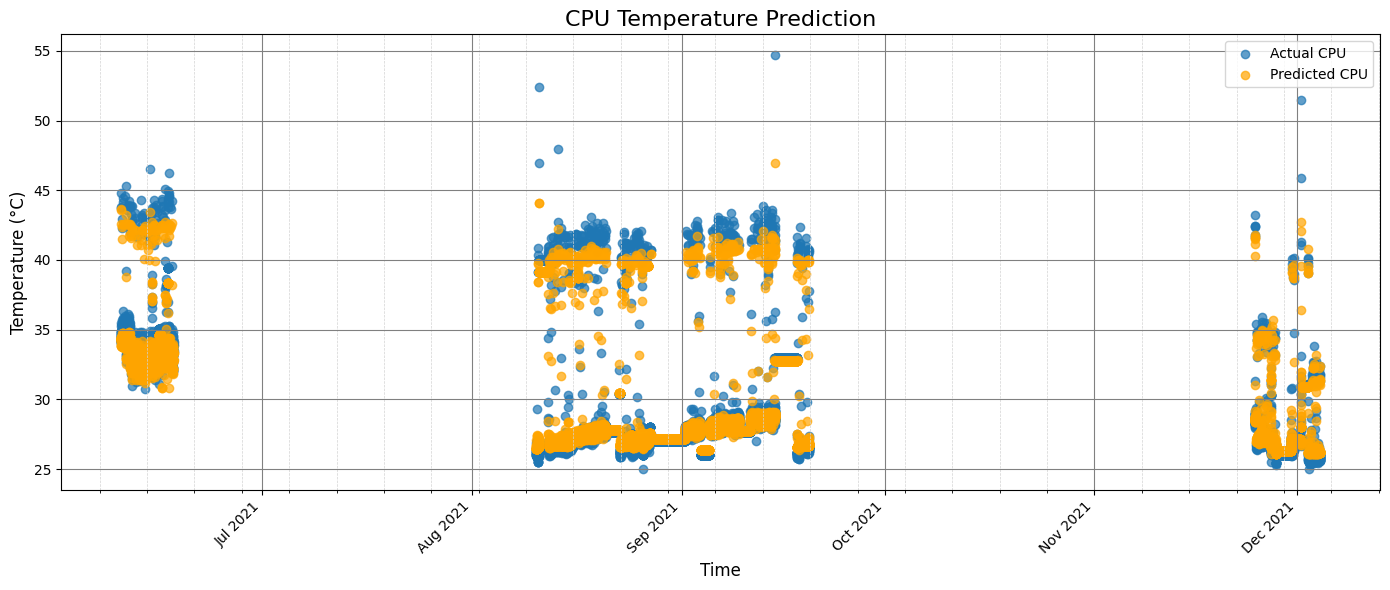

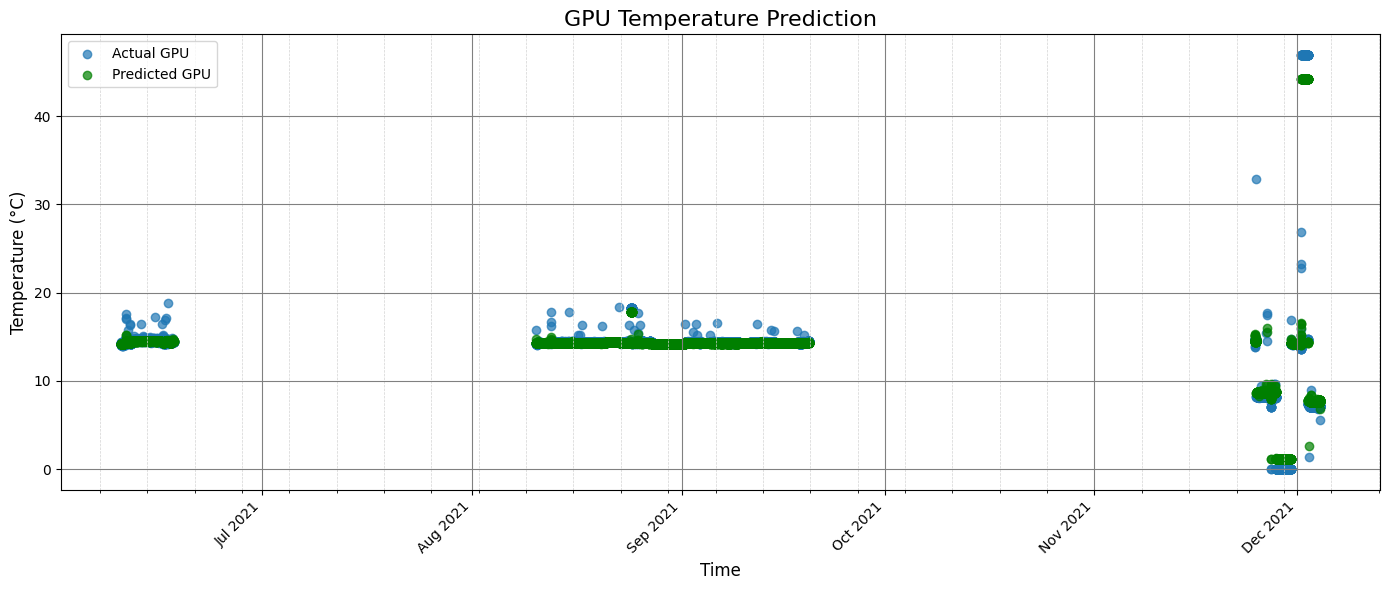

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure indices are datetime
y_cpu_test.index = pd.to_datetime(y_cpu_test.index)
y_gpu_test.index = pd.to_datetime(y_gpu_test.index)

def plot_temp(actual, predicted, title, color_pred):
    fig, ax = plt.subplots(figsize=(14,6))
    
    # Scatter plot
    ax.scatter(actual.index, actual, label=f'Actual {title}', alpha=0.7)
    ax.scatter(actual.index, predicted, label=f'Predicted {title}', color=color_pred, alpha=0.7)

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO))  # every Monday

    ax.grid(which='major', color='gray', linestyle='-', linewidth=0.8)
    ax.grid(which='minor', color='lightgray', linestyle='--', linewidth=0.5)

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    ax.set_title(f"{title} Temperature Prediction", fontsize=16)
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel("Temperature (°C)", fontsize=12)
    ax.legend()
    plt.tight_layout()
    plt.show()

# CPU
plot_temp(y_cpu_test, cpu_pred, 'CPU', 'orange')

# GPU
plot_temp(y_gpu_test, gpu_pred, 'GPU', 'green')
